In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [90]:
df=pd.read_csv('drive/MyDrive/lab4/Vietcombank.csv')
df
df1=df.reset_index()['Close']

In [91]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,21529.789062,21628.097656,20939.931641,21234.859375,21234.859375,1549694
1,2016-01-05,21087.396484,21333.169922,20841.621094,20890.777344,20890.777344,2305491
2,2016-01-06,20890.777344,21234.859375,20890.777344,21136.550781,21136.550781,1616259
3,2016-01-07,21038.240234,21087.396484,20645.003906,20890.777344,20890.777344,1903089
4,2016-01-08,20792.466797,20939.931641,20497.539062,20743.312500,20743.312500,1375938
...,...,...,...,...,...,...,...
2038,2024-03-14,96000.000000,96100.000000,94600.000000,95000.000000,95000.000000,2347601
2039,2024-03-15,95000.000000,95000.000000,93900.000000,94000.000000,94000.000000,2466500
2040,2024-03-18,94300.000000,94500.000000,92500.000000,93000.000000,93000.000000,1867500
2041,2024-03-19,92500.000000,93500.000000,92500.000000,92500.000000,92500.000000,1060100


In [92]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [93]:
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [94]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [95]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest= create_dataset(test_data, time_step)

In [96]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)



(1533, 100)
(1533,)
(308, 100)
(308,)


In [97]:
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=X_train[0][0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

In [98]:
kf = kf.em(X_train[0])

In [99]:
test_data.shape

(409, 1)

In [100]:
test_observed = test_data
test_predicted, _ = kf.filter(test_observed)


In [101]:
test_predicted.shape

(409, 1)

In [102]:
test_predicted=scaler.inverse_transform(test_predicted)
ytest=ytest.reshape(-1,1)
ytest=scaler.inverse_transform(test_data)

In [103]:
test_rmse = np.sqrt(np.mean((test_predicted - ytest)**2))
test_mae = mean_absolute_error(test_predicted, ytest)
test_mape = np.mean(np.abs(test_predicted - ytest)/np.abs(test_predicted))*100

In [104]:
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 1403.4109750236403
Testing MAPE: 0.630716618802401
Testing MAE: 399.8922439801396


In [105]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape[1]

349

In [106]:
test_data[60:].shape

(349, 1)

In [107]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        #print(x_input)
        yhat, _ = kf.filter(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat[-1].tolist())
        i=i+1
    else:
        x_input = x_input.reshape(n_steps)
        yhat, _ = kf.filter(x_input)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat[-1].tolist())
        i=i+1

Streaming output truncated to the last 5000 lines.
 [0.88431353]
 [0.86431098]
 [0.85349447]
 [0.85426702]
 [0.86913085]
 [0.87655358]
 [0.85834388]
 [0.85670698]
 [0.86047118]
 [0.86255747]
 [0.852923  ]
 [0.85408078]
 [0.85273904]
 [0.85230176]
 [0.84614253]
 [0.8406971 ]
 [0.84150103]
 [0.85035835]
 [0.84808777]
 [0.85164544]
 [0.84678816]
 [0.84348611]
 [0.83553371]
 [0.83294201]
 [0.82779971]
 [0.81323085]
 [0.80246611]
 [0.79637928]
 [0.79353605]
 [0.79089037]
 [0.79002814]
 [0.79748293]
 [0.80850778]
 [0.81124125]
 [0.81299163]
 [0.79207376]
 [0.81276165]
 [0.82809918]
 [0.84513115]
 [0.85326048]
 [0.86106703]
 [0.87220651]
 [0.89044893]
 [0.89467509]
 [0.8908952 ]
 [0.90083725]
 [0.90407738]
 [0.91286913]
 [0.93034642]
 [0.93088509]
 [0.92676298]
 [0.92198145]
 [0.91956361]
 [0.92737096]
 [0.92303912]
 [0.91990831]
 [0.89739966]
 [0.901238  ]
 [0.90678658]
 [0.90601626]
 [0.90146756]
 [0.90428279]
 [0.90434075]
 [0.90178104]
 [0.90610402]
 [0.91696774]
 [0.91964871]
 [0.9059103

In [108]:
# Chuyển danh sách thành mảng numpy
values_array = np.array(lst_output)

# Nếu bạn thực sự cần reshape (ví dụ: thành mảng 2D 1 hàng)
values_reshaped = values_array.reshape(-1, 1)

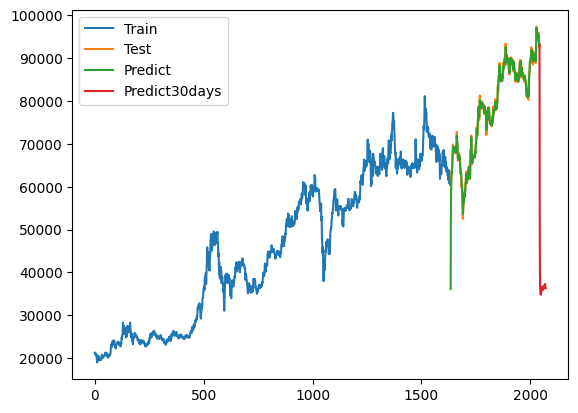

In [109]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,test_predicted)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

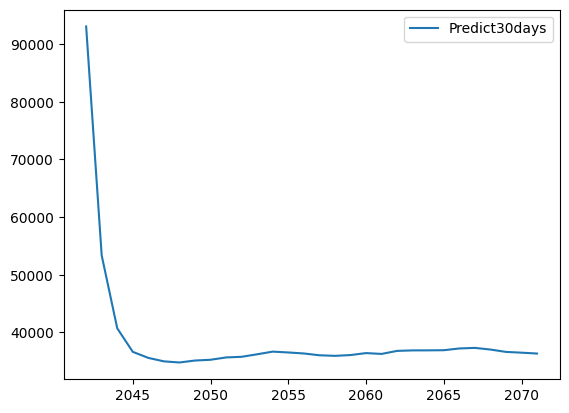

In [110]:
# 14.Vẽ hình
# Dự đoán 30 ngày tiếp theo
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped))
plt.legend(['Predict30days'])
plt.show()